In [1]:
import logging
import sys
import datetime
import pickle
from icecream import ic
from tqdm import tqdm
from sklearn.decomposition import PCA
import seaborn as sns

In [114]:
# for correct lstm shape - https://www.kaggle.com/code/imegirin/multivariate-time-series-modeling-with-pytorch

In [2]:
from torch.utils.data import TensorDataset

In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt;
np.random.seed(42);
from sklearn.metrics import roc_auc_score;

In [4]:
from sklearn.metrics import roc_auc_score;
from sklearn.metrics import classification_report;

In [5]:
pd.set_option('display.max_columns', None);

In [6]:
df=pd.read_pickle('appmath.pkl')[['graph_id', 'user_id', 
       'goal_id',
        'interaction_end_time',
       'learning_objective_name', 'atom_id', 
       'correct', 'time_spent_answering_s', 'time_spent_on_instruction_s',
       'goal_progress',
       'target_status_and_progress', 'prev_concept_narrative',
       'duration_s', 'is_target']]  

In [7]:
df2=pd.read_csv('prereq_edges.csv')

In [8]:
G=nx.Graph()

for _,i in df2.iterrows():    
       
        G.add_edge(i['source_lo_title'],i['dest_lo_title'])
        
subgraphs=[G.subgraph(i) for i in nx.connected_components(G)]

for num,sub in enumerate(subgraphs):
    
    nx.set_node_attributes(sub,num,'subGraphId')

nodeSubGraphId={}
for g in subgraphs:
    for node in g.nodes(data=True):
         nodeSubGraphId[node[0]]= node[1]['subGraphId']
            
subgraphsNodeCountDict={ num: g.number_of_nodes() for num,g in  enumerate(subgraphs)}

In [9]:
for col in df.columns:
    if df[col].dtype.name=='category':
        df[col]=df[col].astype(str)

In [10]:
df['loGraphID']=df.learning_objective_name.apply(lambda x: nodeSubGraphId.get(x) )

In [11]:
difficulty=df[~df.correct.isna()].groupby('atom_id')['correct'].mean().reset_index().rename(columns={'correct':'difficulty'})
df=df.merge(difficulty,how='left',on='atom_id')

In [12]:
lo_difficulty=df[~df.correct.isna()].groupby('learning_objective_name')['correct'].mean().reset_index().rename(columns={'correct':'lo_difficulty'})
df=df.merge(lo_difficulty,how='left',on='learning_objective_name')


In [13]:
def atomClassifier(x):
    if x==None:
        return 'learningMaterial'
    else:
        return 'question'

In [14]:
df['atom_type']=df.correct.apply(lambda x:atomClassifier(x) )

In [15]:
df['correctBinary']=df.correct*1
df.atom_id=df.atom_id.astype(str)


In [16]:
df=df[~df.correctBinary.isna()]

In [17]:
df2['graph_id']=df2.apply(lambda x: nodeSubGraphId.get(x['source_lo_title']) if nodeSubGraphId.get(x['source_lo_title'])!=None else nodeSubGraphId.get(x['dest_lo_title']),axis=1)

In [18]:
unique_lo_graph_id_dic={}
for i in df2.graph_id.unique():
    unique_lo=np.unique(np.concatenate((df2[df2.graph_id==i]['source_lo_title'].unique(),((df2[df2.graph_id==i]['dest_lo_title'].unique())))))
    unique_lo_graph_id_dic[i]={ item:int(num)  for  num,item in enumerate(unique_lo)}
    df2.loc[df2.graph_id==i,'source_index' ]=df2.apply(lambda x: unique_lo_graph_id_dic.get(i).get(x['source_lo_title']),axis=1)
    df2.loc[df2.graph_id==i,'dest_index' ]=df2.apply(lambda x: unique_lo_graph_id_dic.get(i).get(x['dest_lo_title']),axis=1)

In [19]:
df2.source_index=df2.source_index.astype(int)
df2.dest_index=df2.dest_index.astype(int)

In [20]:
df=df[~df.loGraphID.isna()]

In [21]:
#df['loIndex']=df.apply(lambda x: unique_lo_graph_id_dic[x['loGraphID']].get(x['learning_objective_name'] ),axis=1)

In [22]:
df2[df2.graph_id==3].max()

source_lo_id                    eda7ab6a-8070-4fd8-8387-da17a40fd99e
dest_lo_id                      eda7ab6a-8070-4fd8-8387-da17a40fd99e
source_lo_title    Write biconditional statements in symbolic for...
dest_lo_title      Write biconditional statements in symbolic for...
graph_id                                                           3
source_index                                                      30
dest_index                                                        30
dtype: object

In [23]:
summary=df.pivot_table(index='goal_id',aggfunc={'learning_objective_name':pd.Series.nunique,'atom_id':pd.Series.nunique,'user_id':pd.Series.nunique,'interaction_end_time':np.count_nonzero})

In [24]:
summary['atom_usage']=summary.interaction_end_time/summary.atom_id

In [25]:
summary.sort_values('atom_usage',ascending=False).head(10)

,atom_id,interaction_end_time,learning_objective_name,user_id,atom_usage
goal_id,,,,,
39f38cfd-d153-4fcf-950e-5c1b2bfbeaaa,72,8793,3,289,122.125000
d252b7df-6a57-46ff-b4c3-e21d26d80b6a,82,9887,5,253,120.573171
cd26c1cb-87ad-4b57-bdeb-7e8811827e39,59,5764,3,194,97.694915
86940cba-2a55-43a6-8f51-248afca9952d,26,1974,1,291,75.923077
caacf0e3-8698-4806-8ce8-a45d8f75b587,59,4396,3,240,74.508475
12b7f97f-18be-4a9e-9384-866a036631d4,103,7107,5,260,69.000000
9059c88d-ccdd-42dd-a19f-fe7c9bafd6aa,47,3236,2,255,68.851064
46e93a47-9de8-4982-82ec-6e3acb911c54,116,7116,6,240,61.344828
917d2bb2-451f-4f65-8eec-7a8125c9a596,39,2220,2,140,56.923077


In [187]:
loGraphID=3
user=df[df.loGraphID==loGraphID].user_id.sample(2).values

dfg=df[(df.loGraphID==loGraphID) & (df.user_id.isin(user)) ].reset_index(drop=True)

In [188]:
dfg=dfg.sort_values(['user_id','interaction_end_time'])

In [189]:
atom_index={atom_id:i for i,atom_id  in  enumerate(dfg.atom_id.unique())}

In [190]:
dfg['atomIndex']=dfg.atom_id.map(atom_index)

In [191]:
loEdgeMapping=df2[df2['graph_id']==loGraphID][['source_index','dest_index']]
lo_edges=loEdgeMapping.values.transpose()

In [192]:
lo_map=pd.concat([df2[df2['graph_id']==loGraphID][['source_lo_title','source_index']].rename(columns={'source_lo_title':'learning_objective_name','source_index':'loIndex'}),df2[df2['graph_id']==loGraphID][['dest_lo_title','dest_index']].rename(columns={'dest_lo_title':'learning_objective_name','dest_index':'loIndex'})]).drop_duplicates().reset_index(drop=True)

In [193]:
dfg['atomIndex']=dfg.atom_id.map(atom_index)

In [194]:
#loIndex={lo:i for i,lo in enumerate( dfg.learning_objective_name.unique())}
#dfg['loIndex']=dfg['learning_objective_name'].apply(lambda x: loIndex[x])

In [195]:
dfg=dfg.merge(lo_map,on='learning_objective_name',how='left')

In [196]:
dfg

,graph_id,user_id,goal_id,interaction_end_time,learning_objective_name,atom_id,correct,time_spent_answering_s,time_spent_on_instruction_s,goal_progress,target_status_and_progress,prev_concept_narrative,duration_s,is_target,loGraphID,difficulty,lo_difficulty,atom_type,correctBinary,atomIndex,loIndex
0,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,9a9fd7d6-cbbc-4174-8735-24a2bc4ca9f4,dbe7501c-5932-4d44-b41f-de5ef4ad5798,2022-09-13 01:24:49.816,Identify and negate quantified statements,a3e3ad80-e479-4c76-b1fe-2818be405810,False,36.771000,19.398001,0.004846,{'5310af35-3169-4538-a1c9-3a4933b680cd': {'pro...,DIRECT_CHOOSE_TOPIC,56.168999,True,3.0,0.595402,0.486775,question,0,0,16
1,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,9a9fd7d6-cbbc-4174-8735-24a2bc4ca9f4,dbe7501c-5932-4d44-b41f-de5ef4ad5798,2022-09-13 01:25:35.106,Identify and negate simple statements,106d0cd1-7977-48b2-950c-144b5192fea9,True,41.959000,2.988000,0.121728,{'5310af35-3169-4538-a1c9-3a4933b680cd': {'pro...,DIRECT_DIAGNOSE_TOPIC,44.946999,True,3.0,0.695804,0.581220,question,1,1,17
2,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,9a9fd7d6-cbbc-4174-8735-24a2bc4ca9f4,dbe7501c-5932-4d44-b41f-de5ef4ad5798,2022-09-13 01:26:16.318,Identify and negate quantified statements,af31b1fb-8d0f-490f-98c0-5e0bc69ae9fe,False,37.349998,3.526000,0.118187,{'5310af35-3169-4538-a1c9-3a4933b680cd': {'pro...,DIRECT_DIAGNOSE_TOPIC,40.875999,True,3.0,0.495238,0.486775,question,0,2,16
3,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,9a9fd7d6-cbbc-4174-8735-24a2bc4ca9f4,dbe7501c-5932-4d44-b41f-de5ef4ad5798,2022-09-13 01:26:59.496,Identify and negate simple statements,038f2107-3e8a-4bd7-9980-884dc4854ac9,True,40.674000,2.241000,0.257601,{'5310af35-3169-4538-a1c9-3a4933b680cd': {'pro...,DIRECT_DIAGNOSE_TOPIC,42.915001,True,3.0,0.678030,0.581220,question,1,3,17
4,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,9a9fd7d6-cbbc-4174-8735-24a2bc4ca9f4,dbe7501c-5932-4d44-b41f-de5ef4ad5798,2022-09-13 04:19:10.110,Identify and negate simple statements,f01c536d-c25e-4565-8a56-3ec2ff2a6d01,True,27.047001,2.076000,0.384925,{'5310af35-3169-4538-a1c9-3a4933b680cd': {'pro...,DIRECT_DIAGNOSE_TOPIC,29.123001,True,3.0,0.316327,0.581220,question,1,4,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,a00254a5-5444-4527-b5b1-4aa66c2bde6f,5b1889ca-a0ae-48ba-9076-fe94eca8bb21,2022-09-30 11:59:05.270,Identify and validate the standard forms of ar...,e3c2300c-307a-4358-8dd4-64f341476734,True,54.925999,2.688000,1.000000,{'965861e5-3166-4577-95da-2c7795504318': {'pro...,CONTINUED_RECS,57.613998,True,3.0,0.464646,0.502957,question,1,148,18
462,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,a00254a5-5444-4527-b5b1-4aa66c2bde6f,5b1889ca-a0ae-48ba-9076-fe94eca8bb21,2022-09-30 11:59:51.757,Draw a conclusion from a conditional statement,90212e46-137d-44cc-b625-f427a72b5282,True,43.855999,2.427000,1.000000,{'965861e5-3166-4577-95da-2c7795504318': {'pro...,CONTINUED_RECS,46.282997,True,3.0,0.676768,0.676823,question,1,147,15
463,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,a00254a5-5444-4527-b5b1-4aa66c2bde6f,5b1889ca-a0ae-48ba-9076-fe94eca8bb21,2022-09-30 12:00:29.306,Represent a syllogistic argument with a Euler ...,5a33c635-c002-49c1-b30c-7ac3868aa3f2,False,25.900999,11.413000,1.000000,{'965861e5-3166-4577-95da-2c7795504318': {'pro...,CONTINUED_RECS,37.313999,True,3.0,0.598039,0.675532,question,0,176,23
464,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,a00254a5-5444-4527-b5b1-4aa66c2bde6f,fcbc33fa-2004-41bb-ab7b-1650cac23795,2022-09-30 12:04:42.831,Construct a truth table for a statement with a...,78f3fcef-0d2a-4318-a091-fca52e2c664f,False,123.180000,21.658001,0.066586,{'136c6cb0-5549-414b-9a99-d0b4fe774a79': {'pro...,DIRECT_CHOOSE_TOPIC,144.837997,True,3.0,0.457831,0.514105,question,0,293,3


In [197]:
question_sequence=dfg[['loIndex','atomIndex','correctBinary']].values.transpose()

In [198]:
lo_atom_edges_list=dfg.groupby(['loIndex','atomIndex'])['graph_id'].nunique().index.to_list()

In [199]:
question_sequence_len=question_sequence.shape[1]



In [200]:
l1,l2=zip(*lo_atom_edges_list)


In [201]:
lo_atom_edges=np.array((list(l1),list(l2)))

In [202]:
#loFeatures=dfg.groupby('loIndex')['lo_difficulty'].mean().values.reshape(-1,1)
atomFeatures=dfg.groupby('atomIndex')['difficulty'].mean().values.reshape(-1,1)
loFeatures=np.zeros(31 ).reshape(-1,1)

In [203]:
from torch_geometric.data import HeteroData
import torch 


In [204]:
data = HeteroData()

In [205]:
data['atom'].x=torch.tensor(atomFeatures.astype(np.float64)).float()
#data['atom'].y=torch.tensor(atomFeatures.astype(np.float64)).float()
data['lo'].x= torch.tensor(loFeatures.astype(np.float64)).float()

In [206]:
data['lo','lo_atom','atom'].edge_index=torch.from_numpy(lo_atom_edges).long()
data['lo','lo_lo','lo'].edge_index=torch.from_numpy(lo_edges).long()

In [207]:
import torch_geometric.transforms as T

In [208]:
normalize=T.NormalizeFeatures()
data=normalize(data)

In [209]:
import torch_geometric as pyg
from torch_geometric.nn import GCNConv 
from torch_geometric.nn import SAGEConv, to_hetero ,LSTMAggregation
import  torch.nn as nn
import torch.nn.functional as F
import torch 
from torch_geometric.loader import DataLoader

In [210]:
data.metadata()

(['atom', 'lo'], [('lo', 'lo_atom', 'atom'), ('lo', 'lo_lo', 'lo')])

In [211]:
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

In [212]:
hidden_channels=100
final_layer_dim=hidden_channels/4
class GNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels,requires_grad=True)
        self.actfn1=nn.ReLU()
        
        self.conv2 = SAGEConv((-1, -1),int( hidden_channels/2),requires_grad=True)
        self.actfn2=nn.ReLU()
        
        self.conv3 = SAGEConv((-1, -1),int( final_layer_dim),requires_grad=True)
        self.actfn3=nn.ReLU()
        
        self.conv4 = SAGEConv((-1, -1),int( hidden_channels/8),requires_grad=True)
        self.actfn4=nn.ReLU()
        
        
        self.sigmoid= nn.Sigmoid()

    def forward(self, x, edge_index):
        
        x = self.actfn1(self.conv1(x, edge_index))
        #x= F.dropout(x,p=.5,training=self.training)
        
        x = self.actfn2(self.conv2(x, edge_index))
        #x= F.dropout(x,p=.7,training=self.training)
        
        x = self.actfn3(self.conv3(x, edge_index))
        
        #out = self.actfn4(self.conv4(x, edge_index))
        
        #out= F.dropout(x,p=.7,training=self.training)
        #pool={key: gmp(out[key].x, out[key].batch) for key in out.node_types}
        #out=self.sigmoid( self.out(x))
        #ic(pool)
        
        #pool=gmp(out)
        return x

In [151]:
lookback=3
hidden_channels1=int((final_layer_dim)*2*(lookback+1)+(lookback+1))

out_channels=1
class Classifer(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.ins=nn.Linear(hidden_channels1,10)
        self.actfn1=nn.ReLU()
        
        self.ins2=nn.Linear(10,5)
        self.actfn2=nn.ReLU()
        
        self.out=nn.Linear(5,1)
        self.actfn3=nn.Sigmoid()
        
    def forward(self, x):
        
        x= self.actfn1 (self.ins(x))
        
        x= self.actfn2 (self.ins2(x))
        
        out=self.actfn3(self.out(x))
        
        
        return out

In [152]:
class GNN_Classifier(nn.Module):
    def __init__(self):
        super(GNN_Classifier, self).__init__()
        
        self.model_embedding=GNN()
        self.model_embedding = to_hetero(self.model_embedding, data.metadata(),aggr='max')
        self.classifer = Classifer()
        #lo,atom,prev_answer,prev_lo,prev_atom,prev_answer1,prev_lo1,prev_atom1
    def forward(self, x,edges,batch_num,lookback,question_sequence):
        node_embeddings = self.model_embedding(x,edges)
        rnn_input_list=[]
        features_concat_list=[]
        
        for i in range(lookback+1):
            #print([i,batch_num-i])
            lo=question_sequence[0][batch_num-i]
            atom=question_sequence[1][batch_num-i]
            prev_answer=torch.tensor([question_sequence[2][batch_num-1-i]]).float()
            
            features_concat_list.extend([node_embeddings['atom'][atom]])
            features_concat_list.extend([node_embeddings['lo'][lo]])
            features_concat_list.extend([prev_answer])
        
                                         
            
        #user_embeddings=torch.cat([node_embeddings['atom'][atom] , node_embeddings['lo'][lo],prev_answer,node_embeddings['atom'][prev_atom] , node_embeddings['lo'][prev_lo],prev_answer1,node_embeddings['atom'][prev_atom1] , node_embeddings['lo'][prev_lo1]])  
       
        user_embeddings=torch.cat(features_concat_list)
        
        rnn_outputs = self.classifer(user_embeddings)
    
        return rnn_outputs,user_embeddings

In [154]:

model=GNN_Classifier()
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=5e-12)
criterion=torch.nn.BCELoss()
#criterion=F.binary_cross_entropy
train_acc_mean_list=[]
test_acc_mean_list=[]
loss_list=[]
accuracy_list=[]
best_score=0
user_embedings=[]

loss_moving_avg=[]

for epoch_num in range(50):
    epoch_accuracy=[]
    out_list=[]
    total_loss=0
    user_embedings=[]
    prob=[]
    target=[]
    for  batch_num in range(lookback,question_sequence_len):
        
        model.train()
       
        optimizer.zero_grad()   
        #x_dict = {key: gmp(batch[key].x, batch[key].batch) for key in batch.node_types}
        

        answer=torch.tensor([question_sequence[2][batch_num]]).float()
     
        
        out,node_embeddings=model(data.x_dict, data.edge_index_dict,batch_num,lookback,question_sequence) 
        user_embedings.append((node_embeddings,answer))
        loss=F.binary_cross_entropy(out,answer)
        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item())
        total_loss=total_loss+loss.item()
        train_correct=out.round()==answer
        
        train_acc=train_correct*1
        accuracy=(train_correct*1).item()
        epoch_accuracy.append(accuracy)
        #accuracy_list.append(accuracy)
        prob.append(out.item())
        target.append(answer.item())
    performance='epoch {} | loss {:.5f} | accuracy {:.5f} | auc {:.5f}'.format(epoch_num,total_loss/(batch_num+1),np.mean(epoch_accuracy),roc_auc_score(np.array(target),prob))
    print(performance)
    loss_moving_avg.append(total_loss/(batch_num+1))
            
    #ic((epoch_num,np.mean(epoch_accuracy),loss.item()))
    

#out['target']: tensor([[0.2217, 0.0272]], grad_fn=<AddmmBackward0>)

 10%|███████▉                                                                       | 183/1831 [00:03<00:34, 47.99it/s]


KeyboardInterrupt: 

In [156]:
performance

'epoch 14 | loss 0.64085 | accuracy 0.63681 | auc 0.66945'

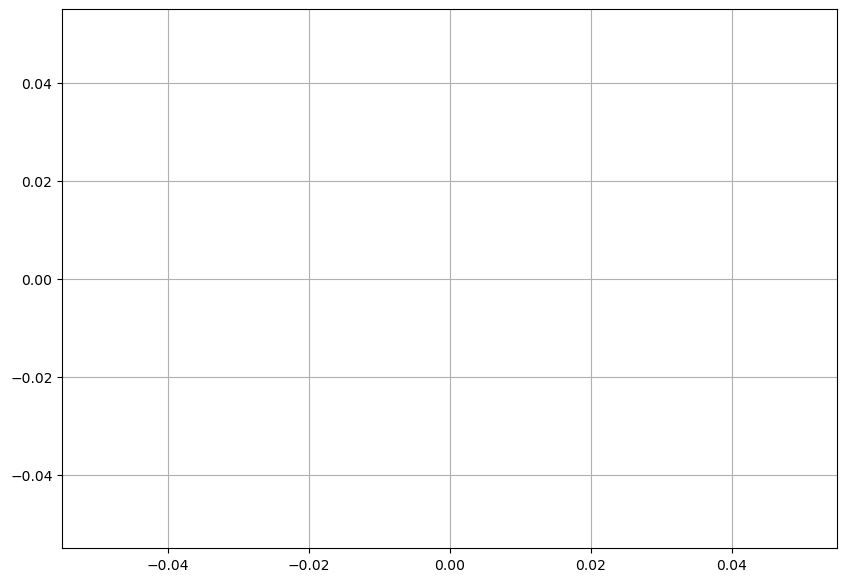

In [157]:
plt.figure(figsize=(10,7))
mvg_steps=question_sequence_len

#for i in range(len(loss_list)-mvg_steps):
#    loss_moving_avg.append(np.mean(loss_list[mvg_steps*i:(i+1)*mvg_steps]))
plt.grid()
#plt.plot(loss_list)
plt.plot(loss_moving_avg)


In [158]:
len(user_embedings)

184

In [159]:
user_embedings[0][0].shape

torch.Size([204])

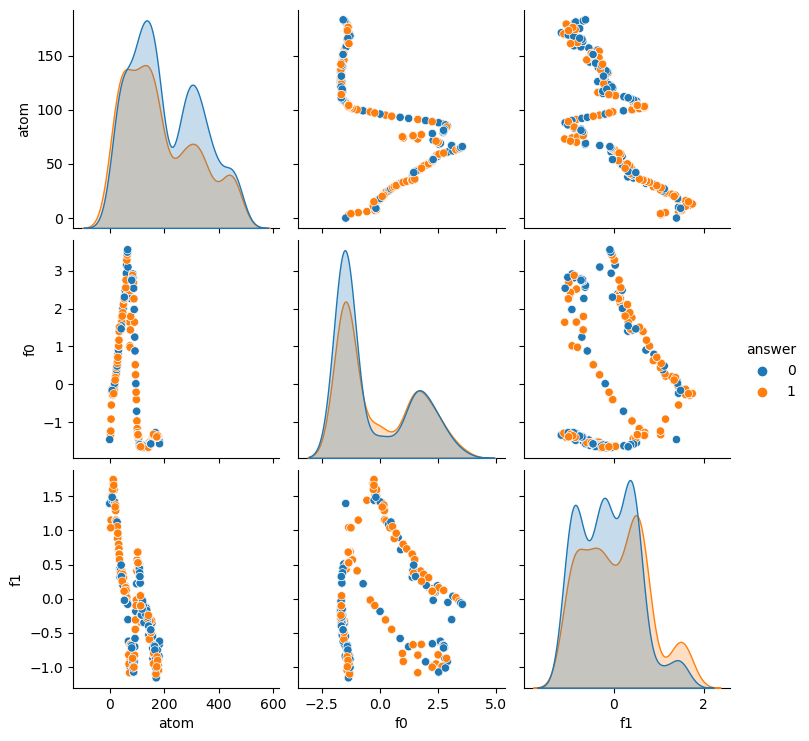

In [160]:
node_embeddings=[i[0] for i in user_embedings]

nodes=torch.stack(node_embeddings).detach().numpy()

nodesDf=pd.DataFrame(nodes[-question_sequence_len:])

pca = PCA(n_components=2)
components = pca.fit_transform(nodesDf)

#pcadf=pd.DataFrame({'f1':components[:,0],'f2':components[:,1]})
pcadf=pd.DataFrame({ 'f'+str(i):components[:,i]  for i in  range(components.shape[1]) })

answersdf=pd.DataFrame({'atom':question_sequence[1][lookback:],'answer':question_sequence[2][lookback:]})

pcadf=pcadf.reset_index().rename(columns={'index':'atom'})

answersdffea=answersdf.merge(pcadf,on='atom',how='left')

sns.pairplot(answersdffea,hue='answer')

In [213]:
hidden_channels=64
final_layer_dim=hidden_channels/4
class GNN_Lstm(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels,requires_grad=True)
        self.actfn1=nn.ReLU()
        
        self.conv2 = SAGEConv((-1, -1),int( hidden_channels/2),requires_grad=True)
        self.actfn2=nn.ReLU()
        
        self.conv3 = SAGEConv((-1, -1),int( final_layer_dim),requires_grad=True)
        self.actfn3=nn.ReLU()
        
        self.conv4 = SAGEConv((-1, -1),int( hidden_channels/8),requires_grad=True)
        self.actfn4=nn.ReLU()
        
        
        self.sigmoid= nn.Sigmoid()

    def forward(self, x, edge_index):
        
        x = self.actfn1(self.conv1(x, edge_index))
        #x= F.dropout(x,p=.5,training=self.training)
        
        x = self.actfn2(self.conv2(x, edge_index))
        #x= F.dropout(x,p=.7,training=self.training)
        
        x = self.actfn3(self.conv3(x, edge_index))
        
        #out = self.actfn4(self.conv4(x, edge_index))
        
        #out= F.dropout(x,p=.7,training=self.training)
        #pool={key: gmp(out[key].x, out[key].batch) for key in out.node_types}
        #out=self.sigmoid( self.out(x))
        #ic(pool)
        
        #pool=gmp(out)
        return x

In [214]:
lookback=3
input_size=33
out_channels=1
num_layers=1
hidden_size=20
class Classifer_Lstm(nn.Module):
    
    def __init__(self ):
        super().__init__()
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        self.sigmoid=nn.Sigmoid()
        
        self.lstm = nn.LSTM(
            input_size=self.input_size ,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self,x):
        #print(x.shape)
        h0 = torch.zeros(self.num_layers, 1, self.hidden_size).requires_grad_()
        # Initialize long-term memory
        c0 = torch.zeros(self.num_layers, 1, self.hidden_size).requires_grad_()
        # Pass all inputs to lstm layer
        out, _ = self.lstm(x, (h0, c0))
        #print(out.shape)
        out = self.sigmoid(self.fc(out[:, -1, :]))
        
        return out

In [215]:
class GNN_LSTM_Classifier(nn.Module):
    def __init__(self):
        super(GNN_LSTM_Classifier, self).__init__()
        
        self.model_embedding=GNN_Lstm()
        self.model_embedding = to_hetero(self.model_embedding, data.metadata(),aggr='max')
        self.classifer = Classifer_Lstm()
        #lo,atom,prev_answer,prev_lo,prev_atom,prev_answer1,prev_lo1,prev_atom1
    def forward(self, x,edges,batch_num,lookback,question_sequence):
        node_embeddings = self.model_embedding(x,edges)
        rnn_input_list=[]
        #features_concat_list=[]
        
        for i in range(lookback+1):
            
            #print([i,batch_num-i])
            lo=question_sequence[0][batch_num-i]
            atom=question_sequence[1][batch_num-i]
            prev_answer=torch.tensor([question_sequence[2][batch_num-1-i]]).float()

            features_concat=torch.cat([node_embeddings['atom'][atom],node_embeddings['lo'][lo],prev_answer])
            rnn_input_list.append(features_concat)
        
                                         
            
        #user_embeddings=torch.cat([node_embeddings['atom'][atom] , node_embeddings['lo'][lo],prev_answer,node_embeddings['atom'][prev_atom] , node_embeddings['lo'][prev_lo],prev_answer1,node_embeddings['atom'][prev_atom1] , node_embeddings['lo'][prev_lo1]])  
       
        rnn_input_stacked=torch.stack(rnn_input_list).view(1,lookback+1,features_concat.shape[0])

        rnn_outputs = self.classifer(rnn_input_stacked)
    
        return rnn_outputs,node_embeddings

In [ ]:

model=GNN_LSTM_Classifier()
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=5e-12)
criterion=torch.nn.BCELoss()
#criterion=F.binary_cross_entropy
train_acc_mean_list=[]
test_acc_mean_list=[]
loss_list=[]
accuracy_list=[]
best_score=0


loss_moving_avg=[]
user_embedings=[]
for epoch_num in range(100):
    epoch_accuracy=[]
    out_list=[]
    total_loss=0
    
    prob=[]
    target=[]
    for  batch_num in range(lookback,question_sequence_len):
        
        model.train()
       
        optimizer.zero_grad()   
        #x_dict = {key: gmp(batch[key].x, batch[key].batch) for key in batch.node_types}
        

        answer=torch.tensor([question_sequence[2][batch_num]]).float()
     
        
        out,node_embeddings=model(data.x_dict, data.edge_index_dict,batch_num,lookback,question_sequence) 
        
        loss=F.binary_cross_entropy(out.view(1),answer)
        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item())
        total_loss=total_loss+loss.item()
        train_correct=out.round()==answer
        
        train_acc=train_correct*1
        accuracy=(train_correct*1).item()
        epoch_accuracy.append(accuracy)
        #accuracy_list.append(accuracy)
        prob.append(out.item())
        target.append(answer.item())
    performance='epoch {} | loss {:.5f} | accuracy {:.5f} | auc {:.5f}'.format(epoch_num,total_loss/(batch_num+1),np.mean(epoch_accuracy),roc_auc_score(np.array(target),prob))
    print(performance)
    loss_moving_avg.append(total_loss/(batch_num+1))
            
    #ic((epoch_num,np.mean(epoch_accuracy),loss.item()))
    

#out['target']: tensor([[0.2217, 0.0272]], grad_fn=<AddmmBackward0>)

epoch 0 | loss 0.67023 | accuracy 0.60475 | auc 0.49363
epoch 1 | loss 0.66747 | accuracy 0.60907 | auc 0.48566
epoch 2 | loss 0.66658 | accuracy 0.60907 | auc 0.49806
epoch 3 | loss 0.66844 | accuracy 0.60907 | auc 0.47044


In [ ]:
performance

In [ ]:
plt.figure(figsize=(10,7))
mvg_steps=question_sequence_len

#for i in range(len(loss_list)-mvg_steps):
#    loss_moving_avg.append(np.mean(loss_list[mvg_steps*i:(i+1)*mvg_steps]))
plt.grid()
#plt.plot(loss_list)
plt.plot(loss_moving_avg)


In [ ]:
atoms=node_embeddings['atom'].detach().numpy()
pca = PCA(n_components=2)
components = pca.fit_transform(atoms)
plt.scatter(components[:,0],components[:,1])

C:\Users\mpathirana\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:545: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


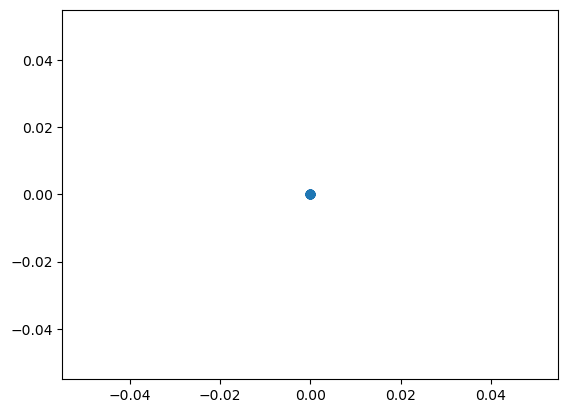

In [173]:
los=node_embeddings['lo'].detach().numpy()
pca = PCA(n_components=2)
components = pca.fit_transform(los)
plt.scatter(components[:,0],components[:,1])

In [ ]:
node_embeddings=[i[0] for i in user_embedings]

nodes=torch.stack(node_embeddings).detach().numpy()

nodesDf=pd.DataFrame([-question_sequence_len:])

pca = PCA(n_components=2)
components = pca.fit_transform(nodesDf)

#pcadf=pd.DataFrame({'f1':components[:,0],'f2':components[:,1]})
pcadf=pd.DataFrame({ 'f'+str(i):components[:,i]  for i in  range(components.shape[1]) })

answersdf=pd.DataFrame({'atom':question_sequence[1][lookback:],'answer':question_sequence[2][lookback:]})

pcadf=pcadf.reset_index().rename(columns={'index':'atom'})

answersdffea=answersdf.merge(pcadf,on='atom',how='left')

sns.pairplot(answersdffea,hue='answer')nodes

In [ ]:
node_embeddings[0].shape